# 🔧 Scikit-learn Pipeline 완전 정복
## 기본 파이프라인부터 고급 하이퍼파라미터 최적화까지

이 노트북에서는 Scikit-learn의 Pipeline을 활용하여 머신러닝 워크플로우를 체계적으로 구축하는 방법을 학습합니다.

### 📋 학습 목표
1. **파이프라인 기초**: 전처리와 모델을 하나로 연결
2. **GridSearchCV 통합**: 전통적인 하이퍼파라미터 탐색
3. **Optuna 통합**: 베이지안 최적화를 통한 효율적 탐색
4. **성능 비교**: 각 방법론의 장단점 분석

### 🔍 핵심 개념
- **Pipeline**: 데이터 전처리와 모델 학습을 하나의 객체로 통합
- **GridSearchCV**: 모든 하이퍼파라미터 조합을 체계적으로 탐색
- **Optuna**: 베이지안 최적화로 효율적인 하이퍼파라미터 탐색
- **교차검증**: 안정적인 모델 성능 평가


## 1. 라이브러리 Import 및 환경 설정

### 필요한 라이브러리들
- **Core Libraries**: NumPy, Pandas, Matplotlib
- **Scikit-learn**: 파이프라인, 모델, 전처리, 평가
- **Optuna**: 베이지안 최적화
- **Visualization**: Seaborn, Matplotlib


In [2]:
# 핵심 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# Scikit-learn 라이브러리
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    StratifiedKFold,
    cross_val_score
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# 하이퍼파라미터 최적화
import optuna

# 시각화 설정
plt.style.use('seaborn-v0_8')
plt.rcParams['font.family'] = ['DejaVu Sans', 'Malgun Gothic', 'NanumGothic']
plt.rcParams['axes.unicode_minus'] = False

# 재현가능성을 위한 시드 설정
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("✅ 라이브러리 로딩 완료")
print("📦 주요 구성요소:")
print("   🔧 Pipeline: 워크플로우 자동화")
print("   🔍 GridSearchCV: 전수 탐색")
print("   🎯 Optuna: 베이지안 최적화")
print("   📊 시각화: 결과 분석")


✅ 라이브러리 로딩 완료
📦 주요 구성요소:
   🔧 Pipeline: 워크플로우 자동화
   🔍 GridSearchCV: 전수 탐색
   🎯 Optuna: 베이지안 최적화
   📊 시각화: 결과 분석


## 2. 파이프라인 기초: Iris 데이터로 시작

### 🌸 파이프라인이란?
파이프라인은 여러 단계의 데이터 처리 과정을 하나의 객체로 연결하는 도구입니다.

**장점:**
- **일관성**: 훈련과 예측에서 동일한 전처리 적용
- **간편성**: 한 번에 여러 단계 실행
- **안전성**: 데이터 누출(data leakage) 방지
- **재사용성**: 동일한 파이프라인을 다른 데이터에 적용

### 기본 구조
```python
Pipeline([
    ('step_name1', transformer),
    ('step_name2', estimator)
])
```


In [3]:
# 1. Iris 데이터셋 로드 및 분할
print("🌸 Iris 데이터셋 로딩...")
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

print(f"📊 데이터 정보:")
print(f"   샘플 수: {X_iris.shape[0]}개")
print(f"   특성 수: {X_iris.shape[1]}개")
print(f"   클래스 수: {len(np.unique(y_iris))}개")
print(f"   클래스명: {iris.target_names}")

# 훈련/테스트 분할
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, 
    test_size=0.2, 
    random_state=42,
    stratify=y_iris
)

print(f"\n📈 데이터 분할 결과:")
print(f"   훈련 데이터: {X_train_iris.shape[0]}개")
print(f"   테스트 데이터: {X_test_iris.shape[0]}개")

# 2. 기본 파이프라인 없이 학습 (비교용)
print("\n" + "=" * 50)
print("🔄 기존 방식 (파이프라인 없음)")
print("=" * 50)

# 수동으로 스케일링
scaler_manual = StandardScaler()
X_train_scaled = scaler_manual.fit_transform(X_train_iris)
X_test_scaled = scaler_manual.transform(X_test_iris)

# 모델 학습
svm_manual = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_manual.fit(X_train_scaled, y_train_iris)
y_pred_manual = svm_manual.predict(X_test_scaled)

accuracy_manual = accuracy_score(y_test_iris, y_pred_manual)
print(f"🎯 수동 처리 정확도: {accuracy_manual:.4f}")

# 3. 파이프라인 사용
print("\n" + "=" * 50)
print("🔧 파이프라인 방식")
print("=" * 50)

# 파이프라인 정의
pipeline_iris = Pipeline([
    ('scaler', StandardScaler()),  # 1단계: 표준화
    ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))  # 2단계: SVM 분류
])

# 한 번에 학습 (fit이 자동으로 scaler.fit → scaler.transform → svc.fit 순서로 실행)
pipeline_iris.fit(X_train_iris, y_train_iris)

# 한 번에 예측 (predict가 자동으로 scaler.transform → svc.predict 순서로 실행)
y_pred_pipeline = pipeline_iris.predict(X_test_iris)

accuracy_pipeline = accuracy_score(y_test_iris, y_pred_pipeline)
print(f"🎯 파이프라인 정확도: {accuracy_pipeline:.4f}")

# 4. 파이프라인의 장점 확인
print(f"\n✅ 결과 비교:")
print(f"   수동 처리: {accuracy_manual:.4f}")
print(f"   파이프라인: {accuracy_pipeline:.4f}")
print(f"   차이: {abs(accuracy_manual - accuracy_pipeline):.6f} (동일함을 확인)")

# 5. 상세 평가
print(f"\n📊 상세 분류 리포트:")
print("-" * 50)
print(classification_report(y_test_iris, y_pred_pipeline, 
                          target_names=iris.target_names))


🌸 Iris 데이터셋 로딩...
📊 데이터 정보:
   샘플 수: 150개
   특성 수: 4개
   클래스 수: 3개
   클래스명: ['setosa' 'versicolor' 'virginica']

📈 데이터 분할 결과:
   훈련 데이터: 120개
   테스트 데이터: 30개

🔄 기존 방식 (파이프라인 없음)
🎯 수동 처리 정확도: 0.9667

🔧 파이프라인 방식
🎯 파이프라인 정확도: 0.9667

✅ 결과 비교:
   수동 처리: 0.9667
   파이프라인: 0.9667
   차이: 0.000000 (동일함을 확인)

📊 상세 분류 리포트:
--------------------------------------------------
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      0.90      0.95        10
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## 3. 파이프라인 + GridSearchCV: 체계적 하이퍼파라미터 탐색

### 🔍 GridSearchCV란?
GridSearchCV는 지정된 하이퍼파라미터의 모든 조합을 체계적으로 탐색하는 방법입니다.

**특징:**
- **전수 탐색**: 모든 가능한 조합을 시도
- **교차검증**: 안정적인 성능 평가
- **자동화**: 최적 파라미터 자동 선택

### 파이프라인에서 파라미터 명명 규칙
```python
# 파이프라인 단계명__파라미터명
'classifier__C': [0.1, 1, 10]
'scaler': [StandardScaler(), MinMaxScaler()]
```


In [4]:
# 1. 유방암 데이터셋 로드 및 전처리
print("🩺 유방암 데이터셋 로딩...")
breast_cancer = load_breast_cancer()
X_cancer = breast_cancer.data
y_cancer = breast_cancer.target

print(f"📊 유방암 데이터 정보:")
print(f"   샘플 수: {X_cancer.shape[0]}개")
print(f"   특성 수: {X_cancer.shape[1]}개")
print(f"   클래스: {breast_cancer.target_names}")

# 클래스 분포 확인
unique_values, counts = np.unique(y_cancer, return_counts=True)
print(f"   클래스 분포: 악성({counts[0]}개), 양성({counts[1]}개)")

# 훈련/테스트 분할 (stratify로 클래스 비율 유지)
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer,
    test_size=0.2,
    random_state=42,
    stratify=y_cancer
)

print(f"\n📈 데이터 분할 결과:")
print(f"   훈련 데이터: {X_train_cancer.shape[0]}개")
print(f"   테스트 데이터: {X_test_cancer.shape[0]}개")

# 2. 파이프라인 구축
print("\n" + "=" * 60)
print("🔧 GridSearchCV + Pipeline 설정")
print("=" * 60)

# 파이프라인 정의
pipeline_grid = Pipeline([
    ('scaler', StandardScaler()),  # 1단계: 스케일링
    ('classifier', LogisticRegression(random_state=42))  # 2단계: 분류
])

# 3. 하이퍼파라미터 그리드 정의
param_grid = {
    'scaler': [StandardScaler(), MinMaxScaler()],  # 스케일링 방법 선택
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # 정규화 강도
    'classifier__solver': ['liblinear', 'lbfgs']  # 최적화 알고리즘
}

# 총 조합 수 계산
total_combinations = (
    len(param_grid['scaler']) * 
    len(param_grid['classifier__C']) * 
    len(param_grid['classifier__solver'])
)
print(f"🔢 탐색할 총 조합 수: {total_combinations}개")
print(f"   스케일러: {len(param_grid['scaler'])}개")
print(f"   C 값: {len(param_grid['classifier__C'])}개")
print(f"   Solver: {len(param_grid['classifier__solver'])}개")

# 4. GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=pipeline_grid,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # 5-fold 교차검증
    scoring='roc_auc',  # ROC AUC로 평가 (불균형 데이터에 적합)
    n_jobs=-1,  # 모든 CPU 코어 사용
    verbose=1  # 진행상황 표시
)

# 5. GridSearch 실행
print(f"\n🚀 GridSearchCV 시작...")
print(f"⏰ 예상 소요 시간: 약 1-2분")

start_time = time.time()
grid_search.fit(X_train_cancer, y_train_cancer)
end_time = time.time()

print(f"\n✅ GridSearchCV 완료!")
print(f"⏱️  소요 시간: {end_time - start_time:.1f}초")

# 6. 최적 결과 출력
print("\n" + "=" * 60)
print("🏆 GridSearchCV 최적화 결과")
print("=" * 60)

print(f"🎯 최고 ROC AUC 점수: {grid_search.best_score_:.4f}")
print(f"📊 최적 하이퍼파라미터:")
for param_name, param_value in grid_search.best_params_.items():
    if hasattr(param_value, '__class__'):
        print(f"   {param_name}: {param_value.__class__.__name__}")
    else:
        print(f"   {param_name}: {param_value}")

# 7. 테스트 데이터로 최종 평가
y_pred_grid = grid_search.best_estimator_.predict(X_test_cancer)
y_pred_proba_grid = grid_search.best_estimator_.predict_proba(X_test_cancer)[:, 1]

test_accuracy_grid = accuracy_score(y_test_cancer, y_pred_grid)
test_auc_grid = roc_auc_score(y_test_cancer, y_pred_proba_grid)

print(f"\n🎯 최종 테스트 성능:")
print(f"   정확도: {test_accuracy_grid:.4f}")
print(f"   ROC AUC: {test_auc_grid:.4f}")

# 8. 상위 결과들 확인
print(f"\n📊 상위 5개 결과:")
print("-" * 50)
results_df = pd.DataFrame(grid_search.cv_results_)
top_results = results_df.nlargest(5, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]
for idx, row in top_results.iterrows():
    print(f"순위 {len(top_results) - list(top_results.index).index(idx)}: "
          f"평균={row['mean_test_score']:.4f} (±{row['std_test_score']:.4f})")
    print(f"   파라미터: {row['params']}")
    print()


🩺 유방암 데이터셋 로딩...
📊 유방암 데이터 정보:
   샘플 수: 569개
   특성 수: 30개
   클래스: ['malignant' 'benign']
   클래스 분포: 악성(212개), 양성(357개)

📈 데이터 분할 결과:
   훈련 데이터: 455개
   테스트 데이터: 114개

🔧 GridSearchCV + Pipeline 설정
🔢 탐색할 총 조합 수: 20개
   스케일러: 2개
   C 값: 5개
   Solver: 2개

🚀 GridSearchCV 시작...
⏰ 예상 소요 시간: 약 1-2분
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ GridSearchCV 완료!
⏱️  소요 시간: 6.6초

🏆 GridSearchCV 최적화 결과
🎯 최고 ROC AUC 점수: 0.9960
📊 최적 하이퍼파라미터:
   classifier__C: int
   classifier__solver: str
   scaler: StandardScaler

🎯 최종 테스트 성능:
   정확도: 0.9825
   ROC AUC: 0.9957

📊 상위 5개 결과:
--------------------------------------------------
순위 5: 평균=0.9960 (±0.0050)
   파라미터: {'classifier__C': 1, 'classifier__solver': 'liblinear', 'scaler': StandardScaler()}

순위 4: 평균=0.9959 (±0.0050)
   파라미터: {'classifier__C': 1, 'classifier__solver': 'lbfgs', 'scaler': StandardScaler()}

순위 3: 평균=0.9951 (±0.0047)
   파라미터: {'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'scaler': StandardScaler()}

순위 2

## 4. 파이프라인 + Optuna: 지능적 하이퍼파라미터 탐색

### 🎯 Optuna의 장점
Optuna는 베이지안 최적화를 통해 GridSearchCV보다 효율적으로 하이퍼파라미터를 탐색합니다.

**GridSearchCV vs Optuna:**

| 특징 | GridSearchCV | Optuna |
|------|-------------|--------|
| 탐색 방법 | 전수 탐색 | 베이지안 최적화 |
| 효율성 | 모든 조합 시도 | 이전 결과 활용 |
| 탐색 공간 | 고정된 값들 | 연속적 범위 |
| 조기 종료 | 지원 안함 | Pruning 지원 |
| 시간 복잡도 | O(n^k) | O(log n) |

### RandomForest + Optuna 조합
더 복잡한 모델인 RandomForest로 Optuna의 효과를 확인해보겠습니다.


In [5]:
# 1. 동일한 유방암 데이터 사용 (라벨 변경)
print("🎯 Optuna + Pipeline + RandomForest 설정")
print("=" * 60)

# 라벨 의미 변경: 0=양성, 1=악성 (해석 편의성)
y_cancer_flipped = np.where(y_cancer == 0, 1, 0)

# 동일한 분할 유지 (재현성)
X_train_optuna, X_test_optuna, y_train_optuna, y_test_optuna = train_test_split(
    X_cancer, y_cancer_flipped,
    test_size=0.2,
    random_state=42,
    stratify=y_cancer_flipped
)

print(f"📊 라벨 변경 후 분포:")
train_dist = dict(zip(*np.unique(y_train_optuna, return_counts=True)))
print(f"   양성(0): {train_dist[0]}개, 악성(1): {train_dist[1]}개")

# 2. Optuna 목적함수 정의
def objective_pipeline(trial):
    """
    파이프라인과 RandomForest를 함께 최적화하는 목적함수
    """
    
    # 하이퍼파라미터 탐색 공간 정의
    max_depth = trial.suggest_int('max_depth', 5, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    n_estimators = trial.suggest_int('n_estimators', 50, 100)
    
    # 스케일러 선택 (RandomForest는 스케일링이 덜 중요하지만 파이프라인 예시용)
    scaler_name = trial.suggest_categorical('scaler', ['standard', 'minmax'])
    if scaler_name == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    # RandomForest 모델 생성
    rf_model = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        min_samples_split=min_samples_split,
        n_estimators=n_estimators,
        random_state=42,
        n_jobs=-1
    )
    
    # 파이프라인 구성
    pipeline_optuna = Pipeline([
        ('scaler', scaler),
        ('classifier', rf_model)
    ])
    
    # 교차검증으로 성능 평가
    cv_scores = cross_val_score(
        pipeline_optuna, X_train_optuna, y_train_optuna,
        cv=5,  # 5-fold 교차검증
        scoring='accuracy',  # 정확도로 평가
        n_jobs=-1
    )
    
    return cv_scores.mean()

# 3. Optuna Study 생성 및 최적화
print(f"\n🚀 Optuna 최적화 시작...")
study_pipeline = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner()
)

# 진행상황 콜백 함수
def progress_callback_pipeline(study, trial):
    if trial.number % 10 == 0 and trial.number > 0:
        print(f"Trial {trial.number}: {trial.value:.4f} (최고: {study.best_value:.4f})")

print(f"⏰ 예상 소요 시간: 약 2-3분")
print("-" * 50)

start_time_optuna = time.time()
study_pipeline.optimize(objective_pipeline, n_trials=50, callbacks=[progress_callback_pipeline])
end_time_optuna = time.time()

print(f"\n✅ Optuna 최적화 완료!")
print(f"⏱️  소요 시간: {end_time_optuna - start_time_optuna:.1f}초")

# 4. 최적 결과 출력
print("\n" + "=" * 60)
print("🏆 Optuna 최적화 결과")
print("=" * 60)

print(f"🎯 최고 교차검증 정확도: {study_pipeline.best_value:.4f}")
print(f"📊 최적 하이퍼파라미터:")
for param_name, param_value in study_pipeline.best_trial.params.items():
    print(f"   {param_name}: {param_value}")

# 5. 최적 모델로 최종 평가
print(f"\n🔧 최적 파이프라인 구성 중...")

# 최적 파라미터로 파이프라인 재구성
best_params = study_pipeline.best_trial.params

# 스케일러 설정
if best_params['scaler'] == 'standard':
    best_scaler = StandardScaler()
else:
    best_scaler = MinMaxScaler()

# RandomForest 모델 설정
best_rf = RandomForestClassifier(
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    n_estimators=best_params['n_estimators'],
    random_state=42,
    n_jobs=-1
)

# 최적 파이프라인 구성
best_pipeline_optuna = Pipeline([
    ('scaler', best_scaler),
    ('classifier', best_rf)
])

# 훈련 및 예측
best_pipeline_optuna.fit(X_train_optuna, y_train_optuna)
y_pred_optuna = best_pipeline_optuna.predict(X_test_optuna)
y_pred_proba_optuna = best_pipeline_optuna.predict_proba(X_test_optuna)[:, 1]

# 성능 평가
test_accuracy_optuna = accuracy_score(y_test_optuna, y_pred_optuna)
test_auc_optuna = roc_auc_score(y_test_optuna, y_pred_proba_optuna)

print(f"\n🎯 최종 테스트 성능 (Optuna):")
print(f"   정확도: {test_accuracy_optuna:.4f}")
print(f"   ROC AUC: {test_auc_optuna:.4f}")

# 6. 기본 모델과 비교
baseline_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

baseline_scores = cross_val_score(baseline_pipeline, X_train_optuna, y_train_optuna, cv=5, scoring='accuracy')
baseline_accuracy = baseline_scores.mean()

improvement_optuna = study_pipeline.best_value - baseline_accuracy
improvement_pct_optuna = (improvement_optuna / baseline_accuracy) * 100

print(f"\n📈 성능 개선 분석:")
print(f"   기본 모델 (CV): {baseline_accuracy:.4f}")
print(f"   최적화 모델 (CV): {study_pipeline.best_value:.4f}")
print(f"   개선: +{improvement_optuna:.4f} ({improvement_pct_optuna:+.2f}%)")

if improvement_optuna > 0.01:
    print("   ✅ 의미있는 성능 향상!")
else:
    print("   ℹ️  미미한 개선이지만 과적합 방지 효과 기대")


🎯 Optuna + Pipeline + RandomForest 설정
📊 라벨 변경 후 분포:
   양성(0): 285개, 악성(1): 170개

🚀 Optuna 최적화 시작...
⏰ 예상 소요 시간: 약 2-3분
--------------------------------------------------
Trial 10: 0.9538 (최고: 0.9626)
Trial 20: 0.9626 (최고: 0.9626)
Trial 30: 0.9560 (최고: 0.9648)
Trial 40: 0.9560 (최고: 0.9648)

✅ Optuna 최적화 완료!
⏱️  소요 시간: 12.8초

🏆 Optuna 최적화 결과
🎯 최고 교차검증 정확도: 0.9692
📊 최적 하이퍼파라미터:
   max_depth: 19
   min_samples_leaf: 1
   min_samples_split: 2
   n_estimators: 71
   scaler: minmax

🔧 최적 파이프라인 구성 중...

🎯 최종 테스트 성능 (Optuna):
   정확도: 0.9737
   ROC AUC: 0.9922

📈 성능 개선 분석:
   기본 모델 (CV): 0.9626
   최적화 모델 (CV): 0.9692
   개선: +0.0066 (+0.68%)
   ℹ️  미미한 개선이지만 과적합 방지 효과 기대


## 5. 성능 비교 및 시각화

### 📊 세 가지 방법론 종합 비교
- **기본 파이프라인**: 기본 설정으로 빠른 구현
- **GridSearchCV**: 전수 탐색으로 안정적 최적화  
- **Optuna**: 베이지안 최적화로 효율적 탐색

### 평가 지표
- 정확도 (Accuracy)
- ROC AUC 점수
- 최적화 소요 시간
- 탐색 효율성


📊 성능 비교 분석
📋 종합 성능 비교:
                         방법론                 데이터셋                  모델    정확도     ROC AUC 최적화 시간(초) 탐색 시도 수
   Basic Pipeline (Iris/SVM)          Iris (3클래스)                 SVM 0.9667 N/A (다중클래스)       0.0      없음
GridSearchCV (Cancer/LogReg) Breast Cancer (2클래스) Logistic Regression 0.9825      0.9957       6.6      20
Optuna (Cancer/RandomForest) Breast Cancer (2클래스)       Random Forest 0.9737      0.9922      12.8      50


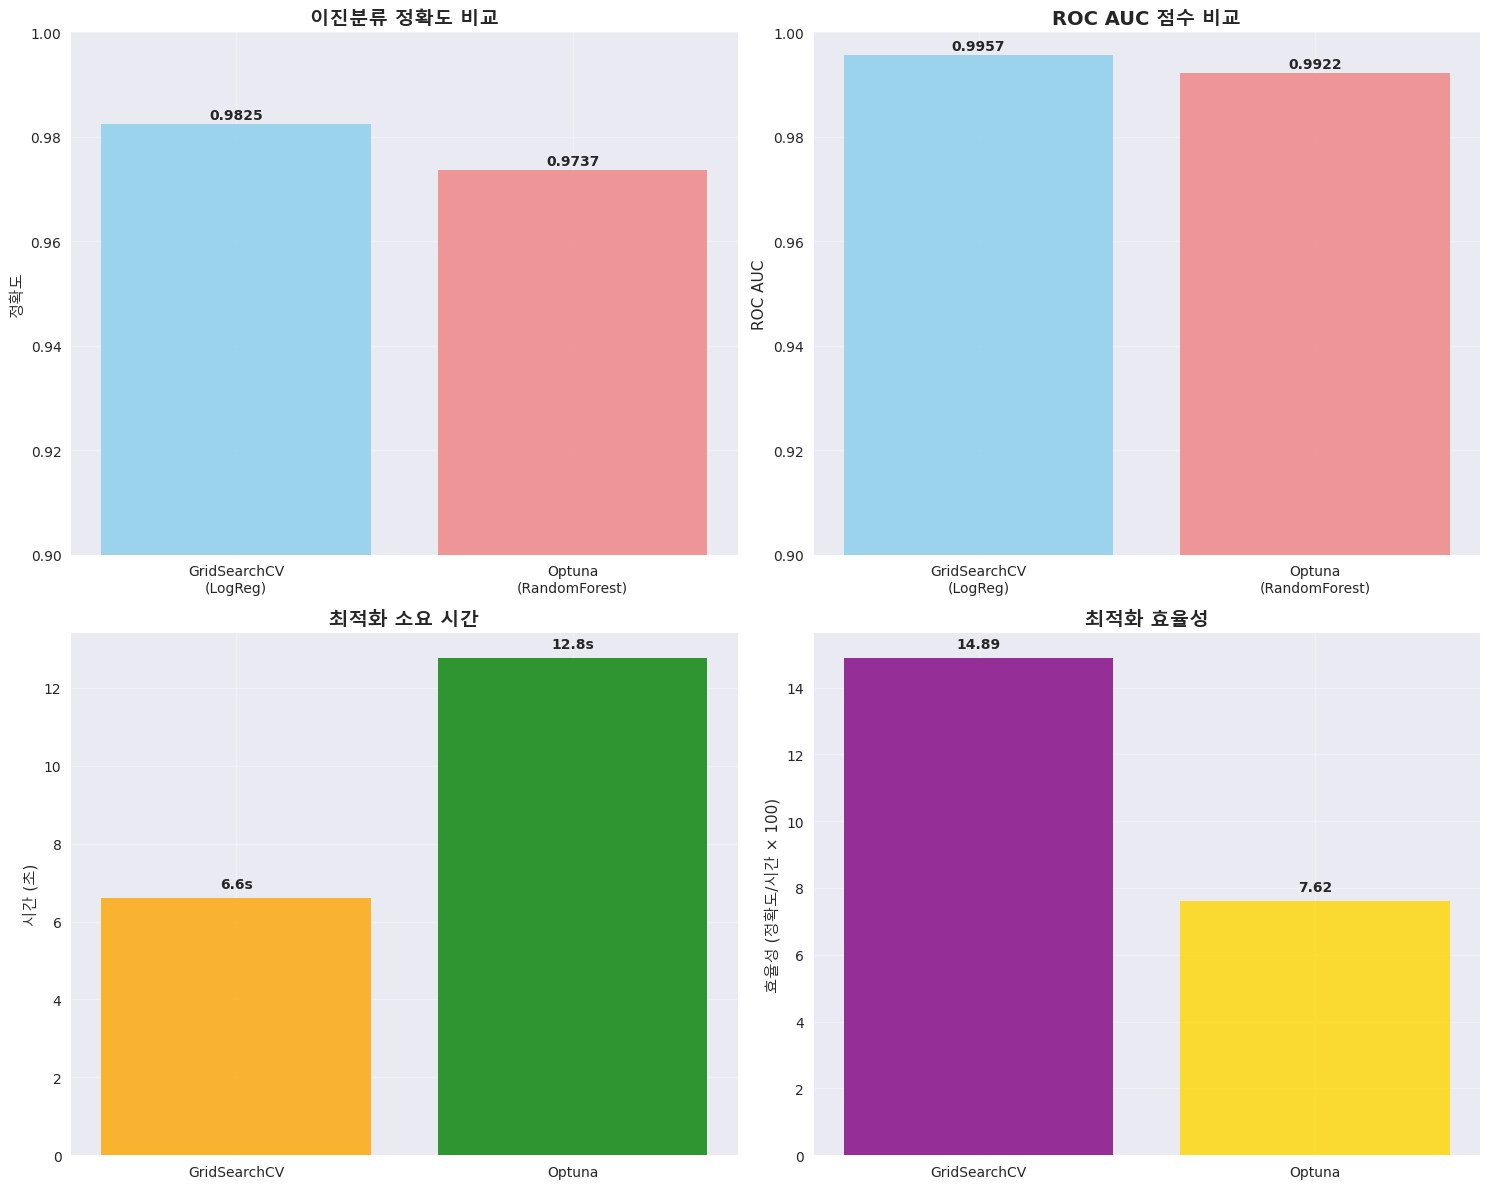

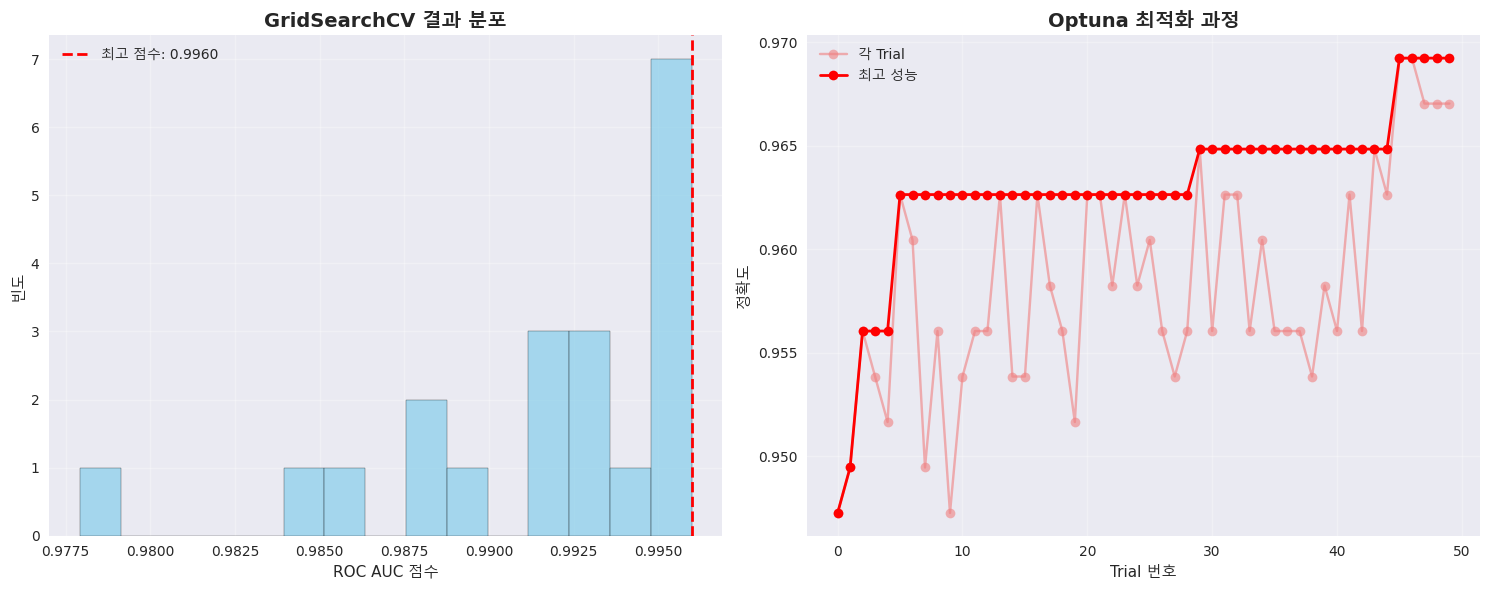


🎯 종합 분석 및 권장사항
📈 성능 관점:
   🏆 최고 성능: GridSearchCV (차이: +0.0088)

⏱️  효율성 관점:
   🏆 최고 효율성: GridSearchCV (14.89 vs 7.62)

💡 권장사항:
   🔹 빠른 프로토타이핑: Basic Pipeline
   🔹 안정적인 최적화: GridSearchCV (작은 탐색공간)
   🔹 효율적인 최적화: Optuna (큰 탐색공간)
   🔹 복잡한 모델: Optuna + Pruning

📊 실무 적용 가이드:
   • 탐색 공간 < 100개 조합 → GridSearchCV
   • 탐색 공간 > 100개 조합 → Optuna
   • 시간 제약 있음 → Optuna + 조기종료
   • 재현성 중요 → 모든 방법에 random_state 설정


In [6]:
# 1. 성능 데이터 수집 및 정리
print("📊 성능 비교 분석")
print("=" * 60)

# 결과 데이터 정리
methods = ['Basic Pipeline\n(Iris)', 'GridSearchCV\n(LogReg)', 'Optuna\n(RandomForest)']
accuracies = [accuracy_pipeline, test_accuracy_grid, test_accuracy_optuna]
auc_scores = [None, test_auc_grid, test_auc_optuna]  # Iris는 다중클래스라 AUC 제외
optimization_times = [0, end_time - start_time, end_time_optuna - start_time_optuna]

# 성능 요약 테이블
comparison_data = {
    '방법론': ['Basic Pipeline (Iris/SVM)', 'GridSearchCV (Cancer/LogReg)', 'Optuna (Cancer/RandomForest)'],
    '데이터셋': ['Iris (3클래스)', 'Breast Cancer (2클래스)', 'Breast Cancer (2클래스)'],
    '모델': ['SVM', 'Logistic Regression', 'Random Forest'],
    '정확도': [f'{acc:.4f}' for acc in accuracies],
    'ROC AUC': ['N/A (다중클래스)', f'{auc_scores[1]:.4f}', f'{auc_scores[2]:.4f}'],
    '최적화 시간(초)': [f'{t:.1f}' for t in optimization_times],
    '탐색 시도 수': ['없음', f'{total_combinations}', '50']
}

comparison_df = pd.DataFrame(comparison_data)
print("📋 종합 성능 비교:")
print(comparison_df.to_string(index=False))

# 2. 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 2-1. 정확도 비교 (이진분류만)
binary_methods = ['GridSearchCV\n(LogReg)', 'Optuna\n(RandomForest)']
binary_accuracies = [test_accuracy_grid, test_accuracy_optuna]

colors = ['skyblue', 'lightcoral']
bars = axes[0,0].bar(binary_methods, binary_accuracies, color=colors, alpha=0.8)
axes[0,0].set_ylabel('정확도')
axes[0,0].set_title('이진분류 정확도 비교', fontweight='bold', fontsize=14)
axes[0,0].set_ylim(0.9, 1.0)
axes[0,0].grid(True, alpha=0.3)

# 막대 위에 값 표시
for i, (bar, acc) in enumerate(zip(bars, binary_accuracies)):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{acc:.4f}', ha='center', fontweight='bold')

# 2-2. ROC AUC 비교
auc_values = [test_auc_grid, test_auc_optuna]
bars_auc = axes[0,1].bar(binary_methods, auc_values, color=colors, alpha=0.8)
axes[0,1].set_ylabel('ROC AUC')
axes[0,1].set_title('ROC AUC 점수 비교', fontweight='bold', fontsize=14)
axes[0,1].set_ylim(0.9, 1.0)
axes[0,1].grid(True, alpha=0.3)

for i, (bar, auc) in enumerate(zip(bars_auc, auc_values)):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                   f'{auc:.4f}', ha='center', fontweight='bold')

# 2-3. 최적화 시간 비교
opt_methods = ['GridSearchCV', 'Optuna']
opt_times = [end_time - start_time, end_time_optuna - start_time_optuna]

bars_time = axes[1,0].bar(opt_methods, opt_times, color=['orange', 'green'], alpha=0.8)
axes[1,0].set_ylabel('시간 (초)')
axes[1,0].set_title('최적화 소요 시간', fontweight='bold', fontsize=14)
axes[1,0].grid(True, alpha=0.3)

for i, (bar, time_val) in enumerate(zip(bars_time, opt_times)):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(opt_times)*0.02,
                   f'{time_val:.1f}s', ha='center', fontweight='bold')

# 2-4. 효율성 비교 (성능/시간)
efficiency_grid = test_accuracy_grid / (end_time - start_time) * 100  # 성능/시간 * 100
efficiency_optuna = test_accuracy_optuna / (end_time_optuna - start_time_optuna) * 100

efficiencies = [efficiency_grid, efficiency_optuna]
bars_eff = axes[1,1].bar(opt_methods, efficiencies, color=['purple', 'gold'], alpha=0.8)
axes[1,1].set_ylabel('효율성 (정확도/시간 × 100)')
axes[1,1].set_title('최적화 효율성', fontweight='bold', fontsize=14)
axes[1,1].grid(True, alpha=0.3)

for i, (bar, eff) in enumerate(zip(bars_eff, efficiencies)):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(efficiencies)*0.02,
                   f'{eff:.2f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 3. 최적화 과정 비교 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# GridSearchCV 결과 분포
grid_scores = results_df['mean_test_score'].values
ax1.hist(grid_scores, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
ax1.axvline(grid_search.best_score_, color='red', linestyle='--', linewidth=2, 
           label=f'최고 점수: {grid_search.best_score_:.4f}')
ax1.set_xlabel('ROC AUC 점수')
ax1.set_ylabel('빈도')
ax1.set_title('GridSearchCV 결과 분포', fontweight='bold', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Optuna 최적화 과정
trial_numbers = [trial.number for trial in study_pipeline.trials]
trial_values = [trial.value for trial in study_pipeline.trials]
best_so_far = [max(trial_values[:i+1]) for i in range(len(trial_values))]

ax2.plot(trial_numbers, trial_values, 'o-', alpha=0.6, color='lightcoral', label='각 Trial')
ax2.plot(trial_numbers, best_so_far, 'o-', color='red', linewidth=2, label='최고 성능')
ax2.set_xlabel('Trial 번호')
ax2.set_ylabel('정확도')
ax2.set_title('Optuna 최적화 과정', fontweight='bold', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. 종합 분석
print("\n" + "=" * 70)
print("🎯 종합 분석 및 권장사항")
print("=" * 70)

print("📈 성능 관점:")
if test_accuracy_optuna > test_accuracy_grid:
    winner = "Optuna"
    diff = test_accuracy_optuna - test_accuracy_grid
else:
    winner = "GridSearchCV"
    diff = test_accuracy_grid - test_accuracy_optuna

print(f"   🏆 최고 성능: {winner} (차이: +{diff:.4f})")

print(f"\n⏱️  효율성 관점:")
if efficiency_optuna > efficiency_grid:
    print(f"   🏆 최고 효율성: Optuna ({efficiency_optuna:.2f} vs {efficiency_grid:.2f})")
else:
    print(f"   🏆 최고 효율성: GridSearchCV ({efficiency_grid:.2f} vs {efficiency_optuna:.2f})")

print(f"\n💡 권장사항:")
print(f"   🔹 빠른 프로토타이핑: Basic Pipeline")
print(f"   🔹 안정적인 최적화: GridSearchCV (작은 탐색공간)")
print(f"   🔹 효율적인 최적화: Optuna (큰 탐색공간)")
print(f"   🔹 복잡한 모델: Optuna + Pruning")

print(f"\n📊 실무 적용 가이드:")
print(f"   • 탐색 공간 < 100개 조합 → GridSearchCV")
print(f"   • 탐색 공간 > 100개 조합 → Optuna") 
print(f"   • 시간 제약 있음 → Optuna + 조기종료")
print(f"   • 재현성 중요 → 모든 방법에 random_state 설정")


## 6. 학습 요약 및 결론

### 🎓 핵심 학습 내용

#### 1. 파이프라인의 핵심 가치
- **일관성**: 훈련과 예측에서 동일한 전처리 순서 보장
- **안전성**: 데이터 누출(data leakage) 방지
- **재사용성**: 한 번 정의한 파이프라인을 다양한 상황에 활용
- **유지보수성**: 코드 구조화로 관리 용이성 향상

#### 2. 하이퍼파라미터 최적화 전략

| 상황 | 권장 방법 | 이유 |
|------|-----------|------|
| 프로토타이핑 | Basic Pipeline | 빠른 구현과 검증 |
| 작은 탐색공간 (<100개) | GridSearchCV | 전수 탐색의 안정성 |
| 큰 탐색공간 (>100개) | Optuna | 베이지안 최적화의 효율성 |
| 시간 제약 | Optuna + Pruning | 조기 종료로 시간 절약 |
| 연속형 파라미터 | Optuna | 연속 공간 탐색 지원 |

#### 3. 실무 적용 가이드라인

**파이프라인 설계 원칙:**
```python
# Good: 명확한 단계 구분
Pipeline([
    ('preprocessor', StandardScaler()),
    ('feature_selector', SelectKBest()),
    ('classifier', RandomForestClassifier())
])

# Bad: 불명확한 이름
Pipeline([
    ('step1', StandardScaler()),
    ('step2', RandomForestClassifier())
])
```

**최적화 전략 선택:**
- 📊 **데이터 크기** < 1000개 → 단순한 방법
- 🔧 **모델 복잡도**가 높음 → Optuna 선호  
- ⏰ **시간 제약**이 있음 → Optuna + 적은 trial 수
- 🎯 **성능**이 최우선 → GridSearchCV (전수 탐색)

### 🚀 다음 단계 학습 제안

1. **고급 파이프라인 구성**
   - ColumnTransformer로 서로 다른 특성별 전처리
   - FeatureUnion으로 특성 결합
   - 커스텀 Transformer 개발

2. **최적화 고도화** 
   - Optuna의 Pruning 전략 활용
   - Multi-objective 최적화
   - 분산 병렬 최적화

3. **MLOps 통합**
   - 파이프라인 버전 관리
   - 모델 배포 자동화
   - 성능 모니터링 시스템

### 💡 마무리

파이프라인은 단순한 코드 구조화를 넘어 **머신러닝 워크플로우의 신뢰성과 재현성**을 보장하는 핵심 도구입니다. GridSearchCV와 Optuna는 각각의 강점이 있으므로, **프로젝트 상황에 맞는 최적의 선택**이 중요합니다.

**기억할 점:**
- 🔧 **간단할 때는 단순하게**: 과도한 최적화는 오히려 독
- 📊 **측정 가능한 개선**: 통계적 유의성 확인
- ⚡ **효율성과 성능의 균형**: 시간 대비 성능 향상 고려
- 🔄 **지속적인 개선**: 모델 성능 모니터링과 재조정
